(Re)extractions of the G140m MM spectra. Inspecting all of them except TRAPPIST-1 and GJ 699, which have already been done in detail.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
import stistools
from astropy.convolution import convolve, Box1DKernel

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [21]:
path = '/home/david/work/muscles/SEDs/lya/'
dpath = path+'data/'
flts = glob.glob(dpath+'*flt.fits')
x1ds = glob.glob(dpath+'*x1d.fits')
raws = glob.glob(dpath+'*raw.fits')

In [22]:
print(len(flts))
print(len(x1ds))
print(len(raws))

19
19
23


In [25]:
froots =[]
xroots = []
rroots = []
for x, f, r in zip(x1ds, flts, raws):
    froots.append(fits.getheader(f)['ROOTNAME'])
    xroots.append(fits.getheader(x)['ROOTNAME'])
    rroots.append(fits.getheader(r)['ROOTNAME'])
for r in rroots:
    if r not in xroots:
        print (r, fits.getheader(dpath+r+'_raw.fits')['TARGNAME'])

odlm30040 LP-756-18
odlm30030 LP-756-18
odlm18040 GJ849
odlm31030 LP-756-18


In [8]:
stars = []
for x in x1ds:
    stars.append(fits.getheader(x)['TARGNAME'])
stars = np.unique(stars)
print(stars)

['GJ1132' 'GJ163' 'GJ649' 'GJ674' 'GJ676A' 'GJ849' 'L-980-5' 'LHS-2686'
 'LP-756-18']


GJ1132
odlm03040
odlm03050


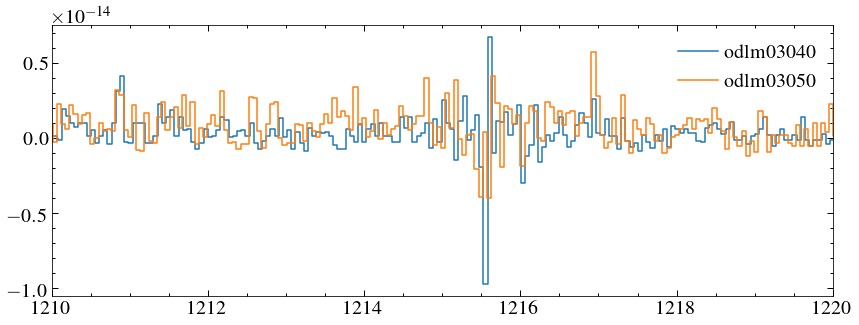

GJ163
odlm15050
odlm15040
odlm15030


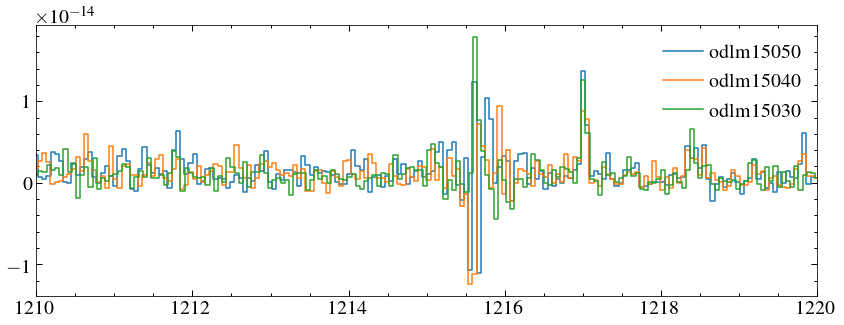

GJ649
odlm12030
odlm12040


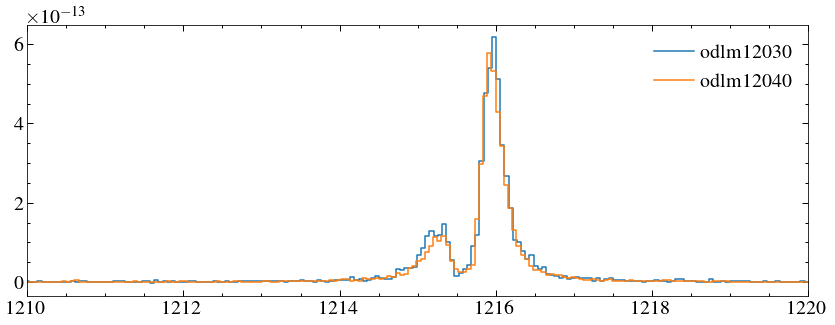

GJ674
odlm21030
odlm21040


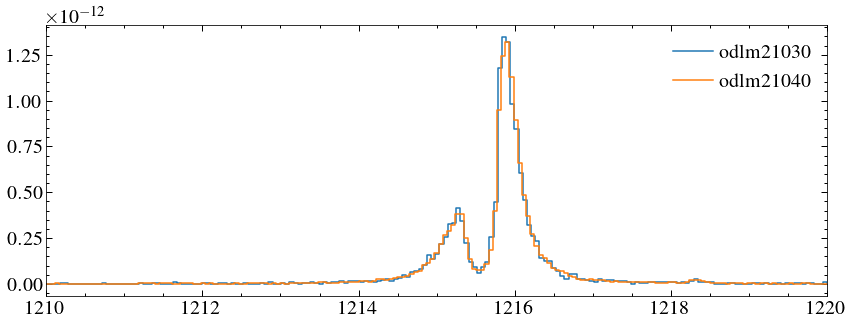

GJ676A
odlm06050
odlm06040


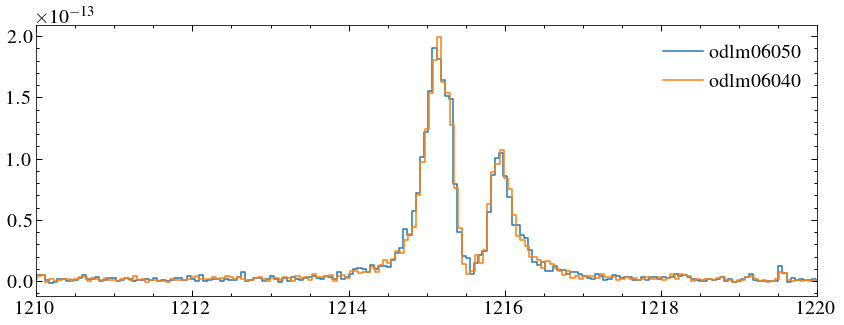

GJ849
odlm18030


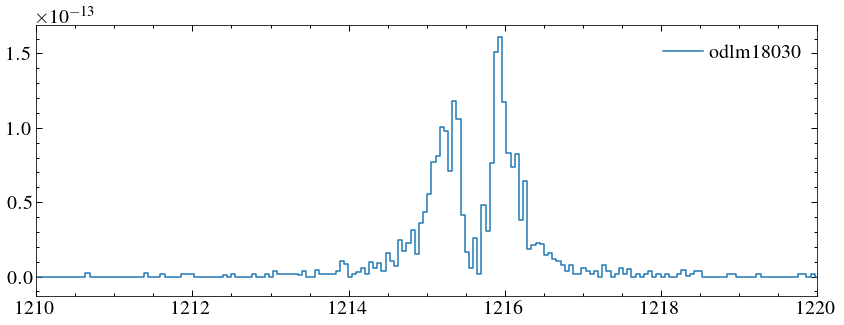

L-980-5
odlm27040
odlm27050


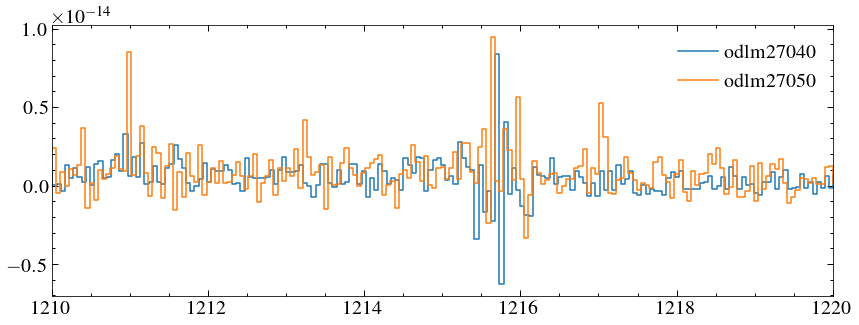

LHS-2686
odlm34030
odlm35040
odlm35030
odlm34040


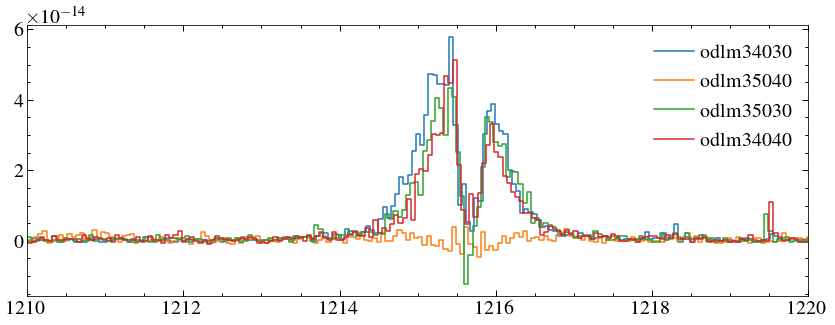

LP-756-18
odlm31040


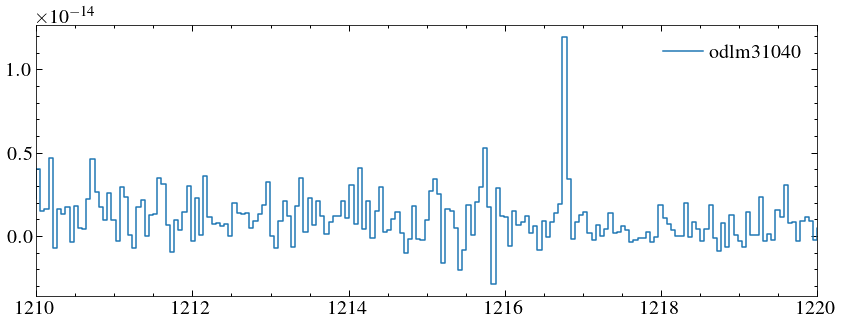

In [12]:
for star in stars:
    print(star)
    for x in x1ds:
        hdul = fits.open(x)
        if hdul[0].header['TARGNAME'] == star:
            data = hdul[1].data[0]
            rootname = hdul[0].header['ROOTNAME']
            print(rootname)
            plt.step(data['WAVELENGTH'], data['FLUX'], where='mid', label=rootname)
        hdul.close()
    plt.xlim(1210, 1220)
    plt.legend()
    plt.show()